# Comparação de Modelos de ML

* Bibliotecas:

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import joblib

* Leitura dos dados:

In [40]:
dados = pd.read_csv('https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/tips.csv')

In [41]:
dados_dict = pd.read_csv('../data/external/dictionary.csv')

In [42]:
dados.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [43]:
dados_dict.head(10)

,variavel,descricao,tipo,subtipo
0,total_bill,Representa o valor total da conta em dólares,quantitativa,contínua
1,tip,Representa o valor da gorjeta em dólares,quantitativa,contínua
2,sex,Indica o sexo da pessoa (Masculino ou Feminino),qualitativa,nominal
3,smoker,Indica se a pessoa é fumante ou não,qualitativa,nominal
4,day,Indica o dia da semana em que a refeição ocorreu,qualitativa,nominal
5,time,Indica se a refeição ocorreu no almoço ou jantar,qualitativa,nominal
6,size,Indica o número de pessoas no grupo,quantitativa,discreta


* Verificando estrutura:

In [44]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


Valores númericos:

In [45]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


Valores de string:

In [46]:
dados.describe(include='object').T

,count,unique,top,freq
sex,244,2,Male,157
smoker,244,2,No,151
day,244,4,Sat,87
time,244,2,Dinner,176


## Tratamento e Transformação de dados:

* Verificando os Valores Faltantes:

In [47]:
valores_nulos = dados.isnull().values.any()

if valores_nulos:
    print("Há valores nulos na tabela.")
else:
    print("Não há valores nulos na tabela.")

Não há valores nulos na tabela.


In [48]:
print(f'Verificando valores faltantes : \n\n{dados.isna().sum()}')

Verificando valores faltantes : 

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


Acima vemos que não há valores nulos no dataset.

* Verificando os Valores discrepantes:

In [49]:
# Função para identificar outliers usando o IQR
def detect_outliers_iqr(dados, column):
    Q1 = dados[column].quantile(0.25)  # Primeiro quartil
    Q3 = dados[column].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1                     # Intervalo Interquartil
    
    lower_bound = Q1 - 1.5 * IQR      # Limite inferior
    upper_bound = Q3 + 1.5 * IQR      # Limite superior
    
    outliers = dados[(dados[column] < lower_bound) | (dados[column] > upper_bound)]
    return outliers

In [50]:
# Detectando outliers apenas para colunas numéricas
for col in dados.select_dtypes(include=[np.number]).columns:  # Filtra apenas colunas numéricas
    outliers = detect_outliers_iqr(dados, col)
    print(f"Outliers na coluna '{col}':\n{outliers}\n")

Outliers na coluna 'total_bill':
     total_bill    tip     sex smoker   day    time  size
59        48.27   6.73    Male     No   Sat  Dinner     4
102       44.30   2.50  Female    Yes   Sat  Dinner     3
142       41.19   5.00    Male     No  Thur   Lunch     5
156       48.17   5.00    Male     No   Sun  Dinner     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
182       45.35   3.50    Male    Yes   Sun  Dinner     3
184       40.55   3.00    Male    Yes   Sun  Dinner     2
197       43.11   5.00  Female    Yes  Thur   Lunch     4
212       48.33   9.00    Male     No   Sat  Dinner     4

Outliers na coluna 'tip':
     total_bill    tip     sex smoker   day    time  size
23        39.42   7.58    Male     No   Sat  Dinner     4
47        32.40   6.00    Male     No   Sun  Dinner     4
59        48.27   6.73    Male     No   Sat  Dinner     4
141       34.30   6.70    Male     No  Thur   Lunch     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
183       23

Acima temos uma lista com os valores discrepantes das colunas númericas.

* Estruturação de Variáveis:

In [51]:
# Definindo a variável-alvo
target_variable = 'tip'

# Identificando variáveis inúteis (nenhuma nesse caso)
useless_variables = (
    dados_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

# Variáveis nominais (não incluímos a variável-alvo)
nominal_variables = (
    dados_dict
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis ordinais (nenhuma foi definida como ordinal no dicionário)
ordinal_variables = (
    dados_dict
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis contínuas
continuous_variables = (
    dados_dict
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis discretas
discrete_variables = (
    dados_dict
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)

* Separando X (variáveis explicativas) e y (variável-alvo):

In [52]:
X = dados.drop(columns=[target_variable] + useless_variables)
y = dados[target_variable]

In [53]:
print("Variáveis nominais:", nominal_variables)
print("Variáveis contínuas:", continuous_variables)
print("Variáveis discretas:", discrete_variables)
print("\nX (features):\n", X)
print("\ny (target):\n", y)

Variáveis nominais: ['sex', 'smoker', 'day', 'time']
Variáveis contínuas: ['total_bill']
Variáveis discretas: ['size']

X (features):
      total_bill     sex smoker   day    time  size
0         16.99  Female     No   Sun  Dinner     2
1         10.34    Male     No   Sun  Dinner     3
2         21.01    Male     No   Sun  Dinner     3
3         23.68    Male     No   Sun  Dinner     2
4         24.59  Female     No   Sun  Dinner     4
..          ...     ...    ...   ...     ...   ...
239       29.03    Male     No   Sat  Dinner     3
240       27.18  Female    Yes   Sat  Dinner     2
241       22.67    Male    Yes   Sat  Dinner     2
242       17.82    Male     No   Sat  Dinner     2
243       18.78  Female     No  Thur  Dinner     2

[244 rows x 6 columns]

y (target):
 0      1.01
1      1.66
2      3.50
3      3.31
4      3.61
       ... 
239    5.92
240    2.00
241    2.00
242    1.75
243    3.00
Name: tip, Length: 244, dtype: float64


O código acima organiza e prepara os dados de forma sistemática para análise ou modelagem. Ele facilita a aplicação de diferentes técnicas a cada tipo de variável, como codificação (para nominais) ou normalização (para contínuas)

* Pipelines de pré-processamento por tipo de variável:

In [54]:

nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),  # Substituir valores faltantes pela moda
    ("encoding", OneHotEncoder(sparse_output=False)),  # Codificação one-hot
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),  # Substituir valores faltantes pela média
    ("normalization", StandardScaler()),  # Normalização (média = 0, desvio padrão = 1)
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),  # Substituir valores faltantes com base nos vizinhos mais próximos
    ("normalization", StandardScaler()),  # Normalização
])


Esse código acima organiza pipelines para pré-processar variáveis diferentes (nominais, ordinais, contínuas e discretas). Cada tipo de variável tem necessidades específicas, como tratamento de valores faltantes ou codificação.

* Selecionando variáveis com base no dados_dict:

In [55]:
# Criando o transformador por tipo de variável
preprocessor = ColumnTransformer(transformers=[
    ("nominal", nominal_preprocessor, nominal_variables),
    ("continuous", continuous_preprocessor, continuous_variables),
    ("discrete", discrete_preprocessor, discrete_variables),
])

As variáveis nominais, contínuas e discretas são extraídas do dicionário de dados com base no subtipo. Isso assegura que cada tipo de dado seja tratado com o pipeline apropriado.

*  Aplicando o preprocessor aos dados:

In [56]:
X_preprocessed = preprocessor.fit_transform(X)

Acima Treina o pipeline no dataset (fit) e transforma os dados (transform) de acordo com os passos definidos.

In [57]:
print("Dados pré-processados:")
print(X_preprocessed)

Dados pré-processados:
[[ 1.          0.          1.         ...  0.         -0.31471131
  -0.60019263]
 [ 0.          1.          1.         ...  0.         -1.06323531
   0.45338292]
 [ 0.          1.          1.         ...  0.          0.1377799
   0.45338292]
 ...
 [ 0.          1.          0.         ...  0.          0.3246295
  -0.60019263]
 [ 0.          1.          1.         ...  0.         -0.2212865
  -0.60019263]
 [ 1.          0.          1.         ...  0.         -0.1132289
  -0.60019263]]


Acima estão os resultados dos passos anteriores.

## Análise Comparativa de Modelos

### **Modelo 1 : Regressão**

*  ### Divisão de treino e teste:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression()),
])

In [22]:
# Ajustar o pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'smoker', 'day',
                                                   'time']),
                                                 ('continuous',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer()),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['total_bill']),
                                                 ('discrete',
                                                  Pipeline(steps=[('missing',
                                                                   KNNImputer()),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['size'])])),
                ('model', LinearRegression())])

* ### Avaliar o modelo no conjunto de teste:

In [23]:
# Fazer previsões no conjunto de teste
y_pred = pipeline.predict(X_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [25]:
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Absolute Error (MAE): 0.6671331480264893
Mean Squared Error (MSE): 0.7033566017436103
R² Score: 0.43730181943482516


**Mean Absolute Error (MAE): 0.667** :
Isso significa que, em média, o modelo erra as previsões em 0.667 unidades (provavelmente na mesma escala que os valores reais, como gorjetas). Um MAE menor é sempre melhor.

**Mean Squared Error (MSE): 0.703**:
Assim como o MAE, mede o erro médio, mas penaliza erros maiores devido ao quadrado das diferenças. É útil para encontrar grandes discrepâncias, mas menos intuitivo que o MAE. Não parece haver erros extremamente altos nas previsões.

**R² Score: 0.437**:
O R² mede quanto da variabilidade nos dados é explicada pelo modelo. Um valor de 0.437 indica que o modelo explica 43,7% da variância nos dados. O modelo explica menos da metade da variância, o que sugere que pode haver espaço para melhorias (dados adicionais ou modelos mais complexos podem ajudar).



*  ### Analisar os coeficientes do modelo:

 os coeficientes podem ser analisados para entender a relação entre as variáveis independentes e a variável dependente.

In [26]:
# Obter os nomes das colunas após o pré-processamento
preprocessor = pipeline.named_steps["preprocessor"]
processed_features = preprocessor.get_feature_names_out()

In [27]:
# Obter os coeficientes da regressão linear
model = pipeline.named_steps["model"]
coefs = model.coef_
features = X_train.columns

In [28]:
# Criar o DataFrame com os coeficientes e as features
coef_df = pd.DataFrame({"Feature": processed_features, "Coefficient": coefs})
print(coef_df.sort_values(by="Coefficient", ascending=False))

                   Feature  Coefficient
10  continuous__total_bill     0.828432
11          discrete__size     0.219073
4         nominal__day_Fri     0.104075
2       nominal__smoker_No     0.096177
6         nominal__day_Sun     0.053282
9      nominal__time_Lunch     0.047479
1        nominal__sex_Male     0.014410
0      nominal__sex_Female    -0.014410
8     nominal__time_Dinner    -0.047479
7        nominal__day_Thur    -0.075646
5         nominal__day_Sat    -0.081710
3      nominal__smoker_Yes    -0.096177


Os coeficientes mostram como cada feature influencia a variável alvo (dentro da escala dos dados). Vamos analisar os maiores impactos:

**Positivos relevantes**:
1. **continuous__total_bill (0.828)**: Essa variável tem a maior influência positiva, o que sugere que, à medida que a conta aumenta, a gorjeta também aumenta proporcionalmente.
2. **discrete__size (0.219)**: Tamanho da mesa também tem um impacto positivo, mas menor.


**Negativos relevantes**:
1. **nominal__smoker_Yes (-0.096)**: Fumantes tendem a dar gorjetas menores.
2. **nominal__day_Sat (-0.082)**: Aos sábados, as gorjetas são ligeiramente menores.

As variáveis total_bill e size são as mais impactantes para prever gorjetas. Algumas variáveis categóricas, como o dia da semana ou se a pessoa fuma, têm menos influência. Se os resultados fazem sentido no contexto, o modelo parece capturar relações razoáveis.

* ### Validar o modelo com validação cruzada:

In [29]:
# Realizar validação cruzada
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())

Cross-Validation R² Scores: [0.52819606 0.59245311 0.40773384 0.20031853 0.37848938]
Mean R² Score: 0.4214381833780753


**Cross-Validation R² Scores: Variam de 0.200 a 0.592** -> 
Isso indica que o modelo tem desempenho inconsistente dependendo da divisão dos dados. A média de 0.421 confirma o desempenho moderado do modelo. Pode ser útil tentar outro modelo (como Random Forest ou Gradient Boosting) para melhorar a estabilidade e a explicação da variância

* ### Fazer previsões em novos dados:

In [30]:
# Exemplo de novos dados para previsão
new_data = pd.DataFrame({
    "total_bill": [20.53, 35.45],
    "sex": ["Male", "Female"],
    "smoker": ["No", "Yes"],
    "day": ["Fri", "Sat"],
    "time": ["Dinner", "Lunch"],
    "size": [2, 4]
})

In [31]:
# Aplicar as transformações e prever
predictions = pipeline.predict(new_data)
print("Predicted Tips:", predictions)

Predicted Tips: [3.16738843 4.73527568]


**Predicted Tips: [3.167, 4.735]**:
Essas previsões são valores plausíveis, mas, novamente, a precisão vai depender de quão bem o modelo generaliza para novos exemplos.

* ### Salvar o Modelo Treinado:

In [32]:
# Salvar o pipeline treinado
joblib.dump(pipeline, "pipeline_model.pkl")

['pipeline_model.pkl']

In [33]:
# Carregar o pipeline salvo
loaded_pipeline = joblib.load("pipeline_model.pkl")

### **Modelo2: Classificação**

In [66]:
# Divida y em quartis (4 categorias)
y_categorical = pd.qcut(y, q=4, labels=["Muito Baixa", "Baixa", "Alta", "Muito Alta"])
print("Categorias geradas:", y_categorical.unique())

Categorias geradas: ['Muito Baixa', 'Alta', 'Muito Alta', 'Baixa']
Categories (4, object): ['Muito Baixa' < 'Baixa' < 'Alta' < 'Muito Alta']


In [69]:
y_categorical = pd.qcut(y, q=4, labels=["Muito Baixa", "Baixa", "Alta", "Muito Alta"])

# Verifique o tamanho de y_categorical
print("Tamanho de y_categorical:", len(y_categorical))


Tamanho de y_categorical: 244


In [70]:
# Agora, divida os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [71]:
# Verifique os tamanhos após a divisão
print("Tamanho de X_train:", X_train.shape[0])
print("Tamanho de y_train:", len(y_train))

Tamanho de X_train: 195
Tamanho de y_train: 195


In [72]:
pipeline1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression()),
])

In [73]:
# Treinar o pipeline
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['sex', 'smoker', 'day',
                                                   'time']),
                                                 ('continuous',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer()),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['total_bill']),
                                                 ('discrete',
                                                  Pipeline(steps=[('missing',
                                                                   KNNImputer()),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['size'])])),
                ('model', LogisticRegression())])

* ###  Avaliação do modelo:

In [74]:
# Fazer previsões
y_pred = pipeline1.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Alta       0.58      0.78      0.67         9
       Baixa       1.00      0.11      0.20         9
  Muito Alta       0.45      0.56      0.50         9
 Muito Baixa       0.68      0.77      0.72        22

    accuracy                           0.61        49
   macro avg       0.68      0.55      0.52        49
weighted avg       0.68      0.61      0.58        49



**MATRIX DE CONFUSÃO**

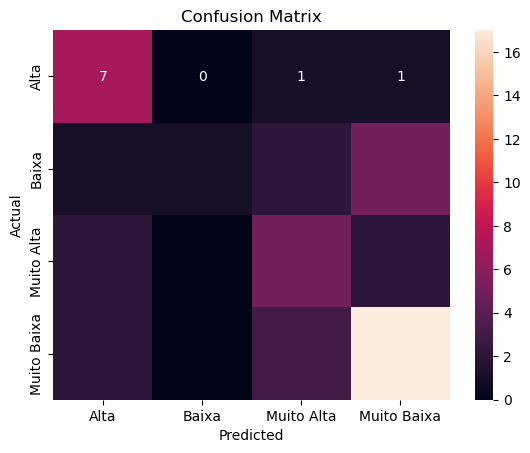

In [76]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline1.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline1.classes_, yticklabels=pipeline1.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

-> Métricas por classe:


* **Alta**:
1. **Precision (0.58)**: 58% das previsões de "Alta" estavam corretas.
2. **Recall (0.78)**: O modelo identificou corretamente 78% das instâncias reais de "Alta".
3. **F1-Score (0.67)**: Combinação balanceada de precisão e recall.

* **Baixa**:
1. **Precision (1.00)**: Todas as previsões de "Baixa" estavam corretas (quando houve previsão).
2. **Recall (0.11)**: Apenas 11% das instâncias reais de "Baixa" foram identificadas pelo modelo.
3. **F1-Score (0.20)**: O baixo recall prejudica o equilíbrio entre precisão e recall.

* **Muito Alta**:
1. **Precision (0.45)**: Apenas 45% das previsões de "Muito Alta" estavam corretas.
2. **Recall (0.56)**: O modelo identificou corretamente 56% das instâncias reais de "Muito Alta".
3. **F1-Score (0.50)**: Indica um desempenho moderado.

* **Muito Baixa**:
1. **Precision (0.68)**: 68% das previsões de "Muito Baixa" estavam corretas.
2. **Recall (0.77)**: O modelo identificou corretamente 77% das instâncias reais de "Muito Baixa".
3. **F1-Score (0.72)**: Melhor equilíbrio entre precisão e recall.

-> Métricas gerais:

* **Acurácia (0.61)**: O modelo previu corretamente 61% das instâncias no conjunto de teste.
* **Macro Avg**:
    * Média não ponderada das métricas para todas as classes, útil quando as classes têm tamanhos semelhantes.
    * **Precision (0.68), Recall (0.55), F1-Score (0.52)**: Indicam que o modelo tem mais dificuldade em prever classes menos representadas.
* Weighted Avg:
    * Média ponderada pelas ocorrências das classes.
    * **Precision (0.68), Recall (0.61), F1-Score (0.58):** Mostram o desempenho geral ajustado aos desequilíbrios do conjunto de dados.

* ### Validação Cruzada

**Cross-Validation**: 

Se quiser validar o modelo em múltiplas divisões, pode usar validação cruzada:

In [82]:
cv_scores = cross_val_score(pipeline1, X, y_categorical, cv=5, scoring="accuracy")
print(f"Validação Cruzada - Acurácia Média: {cv_scores.mean():.2f}")

Validação Cruzada - Acurácia Média: 0.47


A acurácia média de 0.47 na validação cruzada indica que, ao testar o modelo em subconjuntos diferentes dos dados, o desempenho foi menor do que no conjunto de teste. Isso pode significar que o modelo está sensível à divisão dos dados, possivelmente devido à quantidade limitada de dados ou desequilíbrios nas classes.

* ### Predição:

Dados de exemplo para predição:

In [83]:
novos_dados = pd.DataFrame({
    "total_bill": [25.0, 40.5],
    "size": [2, 4],
    "sex": ["Female", "Male"],
    "smoker": ["No", "Yes"],
    "day": ["Sun", "Thur"],
    "time": ["Dinner", "Lunch"]
})

**Predizer classes**

Para obter as categorias previstas:

In [84]:
pred_classes = pipeline1.predict(novos_dados)
print("Previsões de classes:", pred_classes)

Previsões de classes: ['Alta' 'Muito Alta']


As previsões de classes são:

* Exemplo 1: "Alta"
* Exemplo 2: "Muito Alta"

Isso indica que, com base nos dados de entrada, o modelo classificou o primeiro exemplo como pertencente à categoria "Alta" e o segundo como "Muito Alta".



**Predizer probabilidades**

Se quiser obter a probabilidade associada a cada classe:

In [85]:
pred_probas = pipeline1.predict_proba(novos_dados)
print("Probabilidades das classes:")
print(pred_probas)

Probabilidades das classes:
[[0.45405149 0.21506185 0.27894255 0.0519441 ]
 [0.15053493 0.01594897 0.83058902 0.00292708]]


* **EXEMPLO 1** : Probabilidade mais alta para "Alta" (45.4%), que corresponde à previsão feita.
* **EXEMPLO 2** : Probabilidade mais alta para "Muito Alta" (83.1%), que corresponde à previsão feita.